In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Download pbp data for the last 7 years
seasons = range(2016, 2024)
pbp = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [3]:
#Filter pbp data on pass plays
pbp_pass = pbp.query("play_type == 'pass' & passer_id.notnull() & air_yards.notnull()").reset_index()

Restrict air yards to be > 0 and <= 20 yards in order to ensure a large enough sample size. Then, summarize the data to calculate the completion percentage.

In [4]:
#Restrict air yards to be between 0 and 20 yards, then summarize and calculate the completion percentage
pass_pct = pbp_pass.query("0 < air_yards <= 20").groupby('air_yards').agg({'complete_pass': ['mean']})

pass_pct.columns = list(map('_'.join, pass_pct.columns))

pass_pct.reset_index(inplace=True)

pass_pct.rename(columns={'complete_pass_mean': 'comp_pct'}, inplace=True)

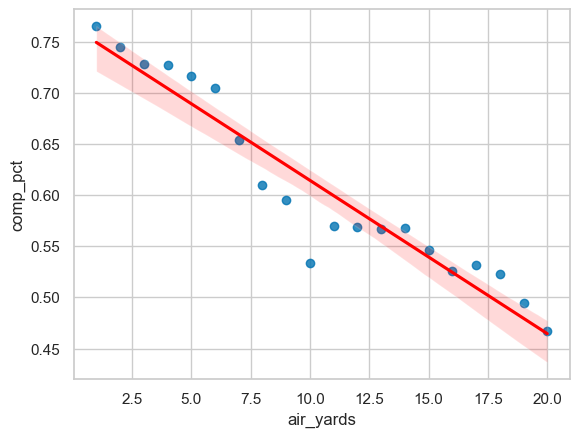

In [6]:
#Show the results in a regression plot
sns.set_theme(style='whitegrid', palette='colorblind')

sns.regplot(data=pass_pct, x='air_yards', y='comp_pct', line_kws={'color': 'red'});

<b>Generalized Linear Model

In [7]:
#Build and fit a GLM
complete_ay = smf.glm(formula='complete_pass ~ air_yards', data=pbp_pass, family=sm.families.Binomial()).fit()

In [9]:
print(complete_ay.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          complete_pass   No. Observations:               150790
Model:                            GLM   Df Residuals:                   150788
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -92792.
Date:                Wed, 26 Jun 2024   Deviance:                   1.8558e+05
Time:                        17:14:43   Pearson chi2:                 1.51e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07053
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0739      0.007    143.202      0.0

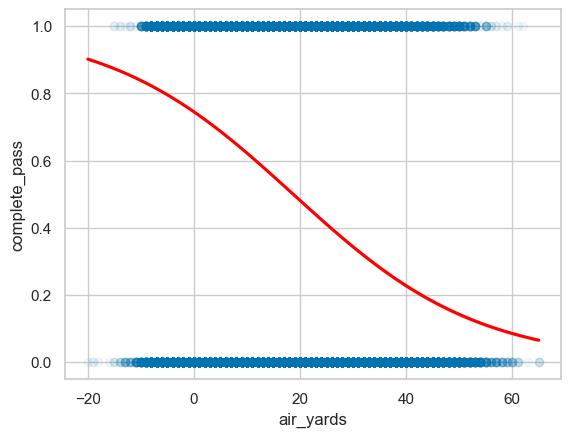

In [12]:
sns.regplot(data=pbp_pass, x='air_yards', y='complete_pass',
            logistic=True,
            line_kws={'color': 'red'},
            scatter_kws={'alpha': 0.05});

In [14]:
#Extract the predictions from the GLM
pbp_pass['exp_completion'] = complete_ay.predict()

In [15]:
#Create a column for CPOE by subtracting the predictions from actual results
pbp_pass['cpoe'] = pbp_pass['complete_pass'] - pbp_pass['exp_completion']

In [20]:
#calculate avg CPOE and completed pass percentage and group by season and passer
cpoe_df = pbp_pass.groupby(['season', 'passer_id', 'passer']).agg({'cpoe': ['count', 'mean'], 'complete_pass': ['mean']})

cpoe_df.columns = list(map('_'.join, cpoe_df.columns))

cpoe_df.reset_index(inplace=True)

In [22]:
#Rename the columns and filter on passers with more than 100 attempts
cpoe_df = (cpoe_df.rename(columns={'cpoe_count': 'n', 
                                  'cpoe_mean': 'cpoe', 
                                  'complete_pass_mean': 'compl'})
                .query('n > 100'))

In [28]:
cpoe_df.sort_values(by='cpoe', ascending=False).head(10)

,season,passer_id,passer,n,cpoe,compl
299,2019,00-0020531,D.Brees,406,0.093767,0.756158
193,2018,00-0020531,D.Brees,566,0.086149,0.738516
467,2020,00-0033537,D.Watson,542,0.073134,0.704797
465,2020,00-0033357,T.Hill,121,0.072179,0.727273
22,2016,00-0026143,M.Ryan,631,0.068614,0.702060
334,2019,00-0029701,R.Tannehill,343,0.068571,0.690962
407,2020,00-0023459,A.Rodgers,607,0.061465,0.705107
96,2017,00-0020531,D.Brees,606,0.058958,0.716172
208,2018,00-0026143,M.Ryan,607,0.058660,0.695222
621,2021,00-0036442,J.Burrow,659,0.056066,0.702580


<b>Generalized Linear Model with Multiple Variables

In [29]:
#Remove missing data and format data
pbp_pass['down'] = pbp_pass['down'].astype(str)
pbp_pass['qb_hit'] = pbp_pass['qb_hit'].astype(str)

In [30]:
pbp_pass_no_miss = (pbp_pass[['passer', 'passer_id', 'season', 'down', 'qb_hit', 'complete_pass', 'ydstogo', 
                             'yardline_100', 'air_yards', 'pass_location']]
                   .dropna(axis=0))

In [31]:
#Build and fit the model
complete_more = (smf.glm(formula='complete_pass ~ down * ydstogo + yardline_100 + air_yards + pass_location + qb_hit',
                        data=pbp_pass_no_miss,
                        family=sm.families.Binomial())
                .fit())

In [47]:
print(complete_more.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          complete_pass   No. Observations:               150761
Model:                            GLM   Df Residuals:                   150748
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -90403.
Date:                Thu, 27 Jun 2024   Deviance:                   1.8081e+05
Time:                        23:32:35   Pearson chi2:                 1.52e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.09919
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [32]:
#Extract the outputs
pbp_pass_no_miss['exp_completion'] = complete_more.predict()

In [33]:
#Calculate CPOE
pbp_pass_no_miss['cpoe'] = pbp_pass_no_miss['complete_pass'] - pbp_pass_no_miss['exp_completion']

In [34]:
#Summarize the outputs and rename columns
cpoe_more_df = (pbp_pass_no_miss.groupby(['season', 'passer_id', 'passer'])
                               .agg({'cpoe': ['count', 'mean'], 
                                     'complete_pass': ['mean'], 
                                     'exp_completion': ['mean']}))

cpoe_more_df.columns = list(map('_'.join, cpoe_more_df.columns))

cpoe_more_df.reset_index(inplace=True)

cpoe_more_df = (cpoe_more_df.rename(columns={'cpoe_count': 'n', 
                                            'cpoe_mean': 'cpoe', 
                                            'complete_pass_mean': 'compl', 
                                            'exp_completion_mean': 'exp_completion'})
                            .query('n > 100'))

In [48]:
cpoe_more_df.sort_values(by='cpoe', ascending=False).head(10)

,season,passer_id,passer,n,cpoe,compl,exp_completion
193,2018,00-0020531,D.Brees,566,0.088237,0.738516,0.650279
299,2019,00-0020531,D.Brees,406,0.087400,0.756158,0.668757
465,2020,00-0033357,T.Hill,121,0.082427,0.727273,0.644846
770,2023,00-0033319,N.Mullens,147,0.080094,0.680272,0.600178
22,2016,00-0026143,M.Ryan,631,0.077098,0.702060,0.624962
467,2020,00-0033537,D.Watson,542,0.072235,0.704797,0.632562
749,2023,00-0029604,K.Cousins,309,0.068348,0.699029,0.630681
334,2019,00-0029701,R.Tannehill,343,0.066261,0.690962,0.624702
204,2018,00-0023682,R.Fitzpatrick,246,0.061024,0.666667,0.605643
31,2016,00-0027854,S.Bradford,551,0.060984,0.716878,0.655895


<b>Analyzing the Predicability of CPOE

In [36]:
#Select the columns to keep
cols_keep = ['season', 'passer_id', 'passer', 'cpoe', 'compl', 'exp_completion']

In [38]:
#Create current dataframe
cpoe_now = cpoe_more_df[cols_keep].copy()

In [39]:
#Create last year's dataframe
cpoe_last = cpoe_more_df[cols_keep].copy()

In [41]:
#Rename columns
cpoe_last.rename(columns={'cpoe': 'cpoe_last', 
                         'compl': 'compl_last', 
                         'exp_completion': 'exp_completion_last'}, 
                         inplace=True)

In [42]:
#Add 1 to season
cpoe_last['season'] += 1

In [43]:
#Merge the dataframes
cpoe_lag = cpoe_now.merge(cpoe_last, how='inner', on=['passer_id', 'passer', 'season'])

In [44]:
#Examine the correlation for pass completion
cpoe_lag[['compl_last', 'compl']].corr()

,compl_last,compl
compl_last,1.00000,0.45061
compl,0.45061,1.00000


In [45]:
#Examine the correlation for CPOE
cpoe_lag[['cpoe_last', 'cpoe']].corr()

,cpoe_last,cpoe
cpoe_last,1.000000,0.466149
cpoe,0.466149,1.000000


CPOE is a slightly more predictable metric year-over-year compared to standard completion percentage